In [1]:
#%pip install matplotlib ipympl

In [2]:
import numpy as np
a = np.array([(1, 2), (1, 2), (5, 6)], dtype=[('x', 'i8'), ('y', 'f4')])
_, i = np.unique(a['x'], return_index=True)
a[i]

array([(1, 2.), (5, 6.)], dtype=[('x', '<i8'), ('y', '<f4')])

In [3]:
import numpy as np

a = np.array([(1, 2), (3, 4), (5, 6)], dtype=[('x', 'i8'), ('y', 'f4')])

import numpy.lib.recfunctions
np.lib.recfunctions.structured_to_unstructured(a).shape


np.vstack([a[field] for field in a.dtype.fields]).shape

(2, 3)

In [4]:
import numpy as np
np.array([(1, 2), (3, 4)], dtype=[('x', 'i8'), ('y', 'f4')])['x']

#np.array(np.array((1, 2), dtype=[('x', 'i8'), ('y', 'f4')]), ndmin=1)

array([1, 3])

In [5]:
np.array([(1, 2)], dtype=[('x', None), ('y', None)]).squeeze()

array((1., 2.), dtype=[('x', '<f8'), ('y', '<f8')])

In [6]:
(*np.asarray([(1, 2), (3, 4)], dtype=[('x', None), ('y', None)]), )


((1., 2.), (3., 4.))

In [7]:
for a in np.asarray([('np', 2), (3, 4)], dtype=[('x', object), ('y', None)]):
    print(a['x'])


np
3


In [23]:

import numpy as _numpy_

class CoordinateView:
    def __init__(self, ndim):
        self._ndim = ndim

    def dtype(self, base=object):
        res_full = [('x', base), ('y', base), ('z', base)]
        if self._ndim > len(res_full):
            raise ValueError(f'ndim {self._ndim} greater than accepted maximum {res_full}.')
        return res_full[:self._ndim]

    def cast(self, arr, base_dtype=object, *np_args, **np_kwargs):
        return _numpy_.array(
            arr, self.dtype(base=base_dtype), 
            *np_args, **np_kwargs,
        )

    def map(self, arr, func, base_dtype=object):
        r"""
        Apply function `func` to every item of `arr`
        # TODO doc apply transformation func to each element of the coordinate system array
        """
        return self.cast([
            tuple(func(element) for element in row)
            for row in self.cast(arr, ndmin=1, base_dtype=object)
        ], base_dtype=base_dtype)
        

_numpy_.testing.assert_array_equal(
    CoordinateView(ndim=2).map(
        [(2, 3)],
        lambda x: x**2,
        base_dtype=object,
    ),
    _numpy_.array([(4., 9.)], dtype=[('x', '<f8'), ('y', '<f8')])    
)


In [9]:
import numpy as _numpy_
from matplotlib.lines import Line2D


class Line2DView:
    def __init__(self, obj: Line2D):
        self._obj = obj

    def _ensure_struct(self, arr):
        # TODO doc accepted value: [(1, 2), (3, 4)] or (1, 2)
        return CoordinateView(ndim=2).cast(arr, ndmin=1)

    @property
    def value(self):
        # TODO doc
        """Get the line data as a structured numpy array."""
        xdata, ydata = self._obj.get_data()
        return self._ensure_struct(
            list(zip(xdata, ydata)),
        )

    @value.setter
    def value(self, value):
        # TODO doc, typing
        """Set the line data from a structured numpy array."""
        #print('TODO rm set value', value)

        value = self._ensure_struct(value)

        self._obj.set_data(
            *([value[field] for field in value.dtype.fields])
        )

        #self._obj.set_data(value['x'], value['y'])

    def extend(self, value):
        # TODO doc, typing
        """Extend the line with more points."""
        value = self._ensure_struct(value)
        self.value = _numpy_.concatenate(
            (self.value, value), 
            #axis=0,
        )

    def clip(self, size):
        self.value = self.value[size:]

    def ensure_unique(self, key):
        _, indices = np.unique(self.value[key], return_index=True)
        self.value = self.value[indices]

In [10]:
import typing as _typing_
import operator as _operator_

import matplotlib as _matplotlib_

# TODO fill in the relevant typing info from matplotlib
class BaseArtistProvider:
    artist: '_matplotlib_.artist.Artist'

    def draws_on(self, ax_or_fig: _typing_.Union['_matplotlib_.axes.Axes', '_matplotlib_.figure.Figure']):
        ax_or_fig.add_artist(self.artist)
        return self

# TODO thread safe
class Line2DProvider(BaseArtistProvider):
    def __init__(
        self, 
        # TODO complete doc and type hints:
        # TODO (Line2D) -> (xdata, ydata)
        # TODO ((Line2D) -> (xdata), ydata: (Line2D) -> (ydata))
        # TODO [(Line2D) -> (xdata), ydata: (Line2D) -> (ydata)]
        data_ref: callable,
        update_method: _typing_.Literal['set', 'extend'] = 'extend',
        **mpl_kwargs,
    ):
        self.update_method = update_method
        if isinstance(data_ref, _typing_.Callable):
            self.data_gen = data_ref
        else:
            self.data_gen = lambda data_ref=data_ref: (
                CoordinateView(ndim=2)
                .map(
                    data_ref, _operator_.call, 
                    base_dtype=object,
                )
            )
        self.artist = Line2D([], [], **mpl_kwargs)

    def update(self):
        view = Line2DView(self.artist)

        match self.update_method:
            case 'set':
                view.value = self.data_gen()
            case 'extend':
                view.extend(self.data_gen())
            case _:
                raise ValueError(rf'Unknown update method {self.update_method}')

        return self

In [11]:
%matplotlib widget

class TestLine2DProvider:
    def test_TODO(self):
        import matplotlib.pyplot as _plt_
        import numpy as _numpy_

        _, ax = _plt_.subplots()

        line_provider = Line2DProvider(
            (lambda: _numpy_.random.rand(), lambda: _numpy_.random.rand()),
            update_method='extend',
        ).draws_on(ax)

        for _ in range(100):
            line_provider.update()

In [12]:
# TODO extend Line2DProvider to allow symbolic Variable.Ref s to be specified in addition to funcs
from energyplus.ooep import (
    components as _components_,
    exceptions as _exceptions_,
)

import energyplus.ooep.addons.base as _base_


import typing as _typing_


class VariableLine2DProvider(Line2DProvider, _base_.Addon):
    def __init__(
        self, 
        data_ref: callable,
        event_ref: _components_.events.Event.Ref = None,
        **kwargs,
    ):
        self.var_refs = []
        self.event_ref = event_ref
        if isinstance(data_ref, _typing_.Callable):
            pass
        else:
            def transform(func_or_var):
                nonlocal self
                if isinstance(func_or_var, _components_.variables.BaseVariable.Ref):
                    # TODO
                    self.var_refs.append(func_or_var)
                    return lambda v=func_or_var: self._engine.variables[v].value
                return func_or_var
            data_ref = (
                CoordinateView(ndim=2)
                .map(
                    data_ref, transform, 
                    base_dtype=object,
                )
            )
        super().__init__(data_ref, **kwargs)

    # TODO performance, async update
    def update(self):
        try: super().update()
        except _exceptions_.TemporaryUnavailableError:
            pass

    def __attach__(self, engine):
        super().__attach__(engine=engine)

        for var_ref in self.var_refs:
            self._engine.variables.on(var_ref)

        if self.event_ref is not None:
            self._engine.events.on(
                self.event_ref, 
                lambda _, self=self: self.update(),
            )

        return self

In [13]:
import typing as _typing_
import matplotlib.pyplot as _plt_


class Line2DChart:
    # TODO typing
    def __init__(
        self, 
        line_factory: _typing_.Callable[[], Line2DProvider] = Line2DProvider,
        autoview: bool = True,
    ):
        self.autoview = autoview
        self.line_factory = line_factory
        self.lines: list[Line2DProvider] = []
        self.figure, self.ax = _plt_.subplots()

    def add(self, *args, **kwargs):
        self.lines.append(
            self.line_factory(*args, **kwargs)
                .draws_on(self.ax)
        )
        return self
    
    def update(self):
        # TODO
        for line in self.lines: 
            line.update()
            # TODO mv !!!!!!!!!!!!!
            Line2DView(line.artist).clip(-500)
            Line2DView(line.artist).ensure_unique(key='x')
        
        if self.autoview:
            self.ax.relim()
            self.ax.autoscale_view()
        self.figure.canvas.draw_idle()
        
        return self
    
    def legend(self, *args, **kwargs):
        self.ax.legend(*args, **kwargs)
        return self

class VariableLine2DChart(Line2DChart, _base_.Addon):
    lines: list[VariableLine2DProvider]

    def __init__(self, event_ref: _components_.events.Event.Ref = None):
        super().__init__(line_factory=VariableLine2DProvider)
        self.event_ref = event_ref

    def __attach__(self, engine):
        super().__attach__(engine=engine)
        
        for line in self.lines:
            line.__attach__(self._engine)

        # TODO !!!!!!!
        if self.event_ref is not None:
            self._engine.events.on(
                self.event_ref, 
                lambda _, self=self: self.update(),
            )

        return self

In [14]:
# TODO
from energyplus.ooep import (
    WallClock,
)


class VariableTrend2DChart(VariableLine2DChart, _base_.Addon):
    # TODO type hints
    def add(self, var_ref: ..., *args, **kwargs):
        super().add(
            (WallClock.Ref(), var_ref),
            update_method='extend',
            label=repr(var_ref),
            *args, **kwargs,
        )
        return self


In [15]:
#%matplotlib widget


_ = '''
import matplotlib.pyplot as _plt_
fig, ax = _plt_.subplots()

    ,
    var_2dline := VariableLine2DProvider((
        #WallClock.Ref(), 
        OutputVariable.Ref(
            type='People Air Temperature',
            key='CORE_MID',
        ),
        OutputVariable.Ref(
            type='People Air Temperature',
            key='CORE_MID',
        ),
    ), event_ref='begin_zone_timestep_after_init_heat_balance')
    .draws_on(ax)

'''

  0%|          | 0/100 [00:00<?, ?it/s]

<Task pending name='Task-8' coro=<Engine.run() running at /home/user@AD/lab/EnergyPlus-OOEP/packages/energyplus/ooep/utils/awaitables.py:68>>

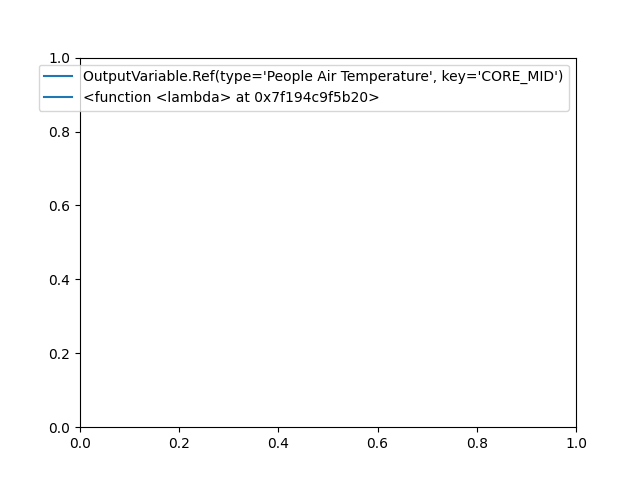

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (500,) and arg 1 with shape (501,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (500,) and arg 1 with shape (501,).

In [2]:
%matplotlib widget

from energyplus.ooep.addons.display.viz import VariableTrend2DChart

from energyplus.ooep.addons.display import ProgressProvider

from energyplus.ooep import (
    Simulator,
    Model,
    Weather,
    Report,
)
from energyplus.ooep import (
    WallClock,
    OutputVariable,
)

from energyplus.dataset.basic import dataset as _epds_


simulator = Simulator().add(
    ProgressProvider(),
    #LogProvider(),
    #var_line2d := (
    #    VariableLine2DChart(event_ref='begin_zone_timestep_before_init_heat_balance')
    #    .add((
    #        WallClock.Ref(), 
    #        OutputVariable.Ref(
    #            type='People Air Temperature',
    #            key='CORE_MID',
    #        ),
    #    ), label='test', update_method='extend')
    #    .legend()
    #),
    # TODO
    var_trend := (
        VariableTrend2DChart(event_ref='begin_zone_timestep_before_init_heat_balance')
            .add(
                OutputVariable.Ref(
                    type='People Air Temperature',
                    key='CORE_MID',
                )
            )
            .add(lambda: 1)
            .legend()
    ),
)

await simulator.awaitable.run(
    input=Simulator.InputSpecs(
        model=Model().open(
            _epds_.models / 'ASHRAE901_OfficeLarge_STD2019_Denver_Chiller205_Detailed.idf'
        ),
        weather=Weather().open(_epds_.weathers / 'USA_FL_Tampa.Intl.AP.722110_TMY3.epw'),
    ),
    output=Simulator.OutputSpecs(
        report=Report().open('.ooep-report-9e1287d2-8e75-4cf5-bbc5-f76580b56a69'),
    ),
    options=Simulator.RuntimeOptions(
        #design_day=True,
    ),
)



In [23]:
simulator.variables.keys().group(type)[OutputVariable.Ref]

In [ ]:
#%pip install --upgrade matplotlib ipympl

In [ ]:
var_line2d.figure.canvas.draw()

In [ ]:
#simulator.stop()

In [ ]:
var_line2d.lines[0].artist

In [ ]:
var_line2d.update()

In [ ]:
var_line2d.lines[0].artist.get_data()

In [ ]:
#var_line2d.lines[0].artist.get_data()[1].shape


In [ ]:
#var_line2d.update()

In [ ]:
def TODO_mv():
    import matplotlib.pyplot as _plt_

    fig, ax = _plt_.subplots()
    line, = ax.plot([])
    for x in range(10):
        Line2DView(line).extend((x, x**2))
        ax.relim()
        ax.autoscale_view()
        #fig.canvas.draw()

    Line2DView(line).value

In [ ]:
class FigureProvider:
    pass

    def _TODO(self):
        pass

In [ ]:
import dataclasses as _dataclasses_

class Trend2DVisualizer:
    class LineRefs:
        x: '_components_.variables.BaseVariable.Ref'
        y: ...
        pass

    @_dataclasses_.dataclass
    class LineInfo:
        inst: Line2D
        refs: 'Trend2DVisualizer.LineRefs'

    line_infos: list[LineInfo]

    def _TODO_add(self, refs: LineRefs):
        # TODO
        figure = _plt_.figure()

        self.LineInfo(
            inst=Line2D([]),
            refs=refs,
        )

        # ... TODO add artists to ax
        for line_info in self.line_infos:
            Line2DView(line).extend((
                line_info.spec.x
            ))
        
        pass
    
    def update(self):
        
        pass
    pass

In [ ]:
#_plt_.gcf()
#_plt_.figure()
#_plt_.isinteractive()
#fig.subplots()

# ArtistProvider(...).draws_on(ax=ax)

'''
FigureProvider().axis(

)

'''

In [ ]:
from collections.abc import Callable

class EventSourceBase:
    def start(self) -> None: ...
    def stop(self) -> None: ...
    def add_callback(self, func: Callable, *args, **kwargs) -> Callable: ...
    def remove_callback(self, func: Callable, *args, **kwargs) -> None: ...
